# Capstone 2: Modeling

### 1. Sourcing and Loading

#### 1a. Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from library.sb_utils import save_file

#### 1b. Load the Data

In [2]:
import hickle as hkl

In [3]:
data = hkl.load("stroke_traintest_unscaled_data.hkl")

In [4]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [5]:
# make sure the X data looks correct
X_train.head()

,gender,ever_married,Residence_type,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,id,hypertension,heart_disease,avg_glucose_level,bmi
2331,1,1,0,0,0,1,0,0,0,1,0,0,15351,0,0,91.68,32.4
3901,1,1,1,0,0,1,0,0,0,0,1,0,37479,0,0,93.96,33.3
1436,1,1,0,1,0,0,0,0,0,1,0,0,71318,0,0,244.28,29.4
1018,0,1,0,0,0,0,1,0,1,0,0,0,17437,0,0,85.60,25.9
3567,0,1,0,0,0,0,1,0,0,0,1,0,62475,1,0,88.18,33.5


In [6]:
# remove ID columns for modeling
X_train_id = X_train['id']
X_train = X_train.drop(['id'], axis=1)

X_test_id = X_test['id']
X_test = X_test.drop(['id'], axis=1)

X_train.columns

Index(['gender', 'ever_married', 'Residence_type', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'hypertension',
       'heart_disease', 'avg_glucose_level', 'bmi'],
      dtype='object')

In [7]:
# make sure the y data is there
y_train.head()

2331    0
3901    0
1436    0
1018    0
3567    0
Name: stroke, dtype: int64

In [8]:
# verify data set shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4086, 16)
X_test shape: (1022, 16)
y_train shape: (4086,)
y_test shape: (1022,)


### 2. Create Baseline Models

Now, we can select a few algorithms and create baseline models. In these models, we want to keep things fairly simple and strive to select one or two algorithms to move forward with. Once we select the best models, we can do further parameter testing and try to optimize the performance. Speaking of performance, we will look at the ROC curves for the baseline models to determine their performace. Furthermore, reducing false-negative predictions (predicting non-stroke when actually stroke) is very important in healthcare datasets such as these where the predictions could lead to missing a diagnosis. 

The models that will be tested here are a random forest classifier, support vector machine, logistic regression, XGBoost, and CatBoost.

#### 2a. Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [10]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier()
#rfc_cv = GridSearchCV(rfc, params, scoring='recall', cv=5)
rfc_cv = GridSearchCV(rfc, params, scoring='f1', cv=10)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1')

In [11]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
# create model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=200)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

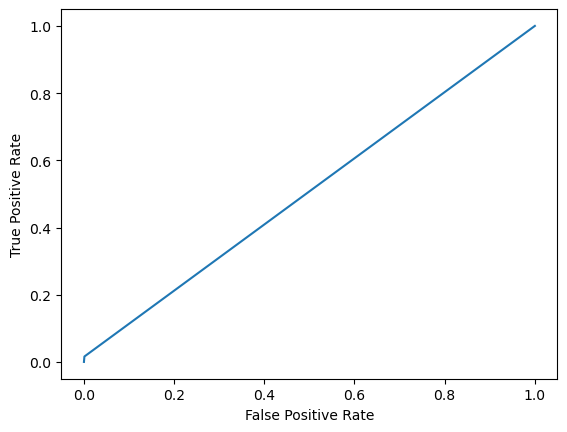

AUC score: 0.5075436827956988


In [13]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [14]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[959,   1],
       [ 61,   1]], dtype=int64)

As we can see from the ROC curve and the confusion matrix, this classifier did a bad job at distinguishing the classes. This model has zero recall, meaning it predicted all observations to be '0'.

#### 2b. Support Vector Machine

In [15]:
from sklearn.svm import SVC

In [16]:
# create grid search and fit model
params = {'C':[0.1, 1, 10, 100, 1000], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC()
svc_cv = GridSearchCV(svc, params, scoring='recall', cv=5)
svc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='recall')

In [17]:
# print best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

Best Parameters: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}


In [18]:
# create model with best parameters
svc = SVC(C=1000, gamma='auto', kernel='rbf')
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

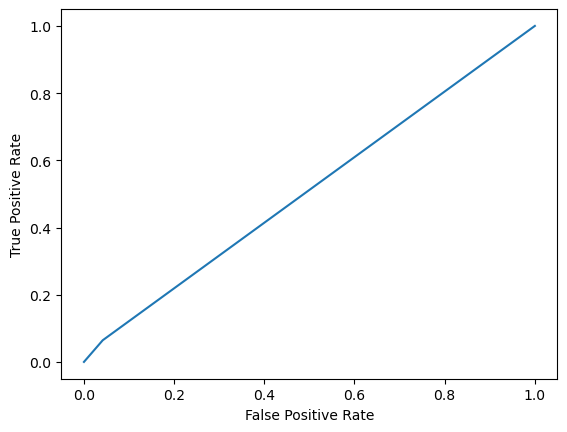

AUC score: 0.5114247311827957


In [19]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [20]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[920,  40],
       [ 58,   4]], dtype=int64)

The same thing happened again: all 62 stroke events were predicted to be non-strokes. This is a problem and a useless model for our goal. We will keep trying to find another model that can distinguish the two classes.

#### 2c. Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
# create grid search and fit model
params = {'penalty':['none', 'l1', 'l2'], 'C':[0.1, 1, 10, 100, 1000]}
logr = LogisticRegression()
logr_cv = GridSearchCV(logr, params, scoring='recall', cv=5)
logr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='recall')

In [23]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'C': 0.1, 'penalty': 'none'}


In [24]:
# create model with best parameters
logr = LogisticRegression(C=0.1, penalty='none')
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_test_pred = logr.predict(X_test)

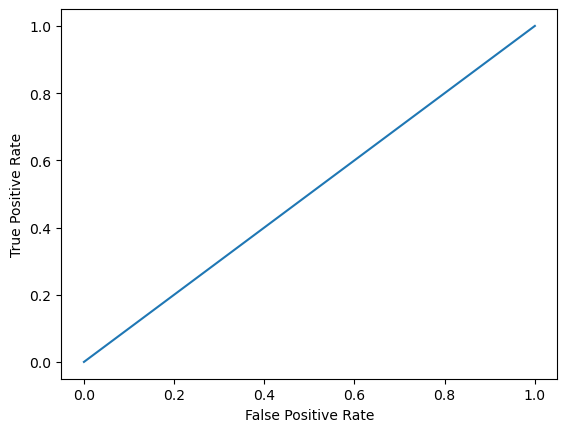

AUC score: 0.5


In [25]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [26]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

Same results...

#### 2d. XGBoost

In [65]:
! pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 1.7 MB/s eta 0:00:00


In [27]:
from xgboost import XGBClassifier

In [28]:
# train general XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
# predict on training and testing sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

y_train_pred = [round(value) for value in y_train_pred]
y_test_pred = [round(value) for value in y_test_pred]

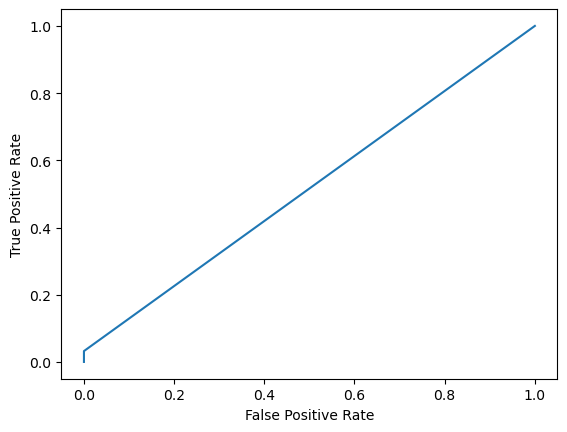

AUC score: 0.5161290322580645


In [30]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [31]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 60,   2]], dtype=int64)

This model predicted 2 stroke victims correctly, and predicted 4 incorrectly. This is better than a recall of zero but needs much improvement to be a sensible model.

#### 2e. CatBoost

In [71]:
! pip install catboost

In [32]:
from catboost import CatBoostClassifier

In [33]:
# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier()
cbc_cv = GridSearchCV(cbc, params, scoring='recall', cv=5)
cbc_cv.fit(X_train,y_train)

0:	learn: 0.6851463	total: 192ms	remaining: 1.73s
1:	learn: 0.6772452	total: 194ms	remaining: 777ms
2:	learn: 0.6696151	total: 196ms	remaining: 457ms
3:	learn: 0.6621179	total: 198ms	remaining: 296ms
4:	learn: 0.6546570	total: 199ms	remaining: 199ms
5:	learn: 0.6475474	total: 200ms	remaining: 133ms
6:	learn: 0.6404727	total: 201ms	remaining: 86.3ms
7:	learn: 0.6333437	total: 202ms	remaining: 50.6ms
8:	learn: 0.6264179	total: 204ms	remaining: 22.6ms
9:	learn: 0.6196091	total: 205ms	remaining: 0us
0:	learn: 0.6851587	total: 1.51ms	remaining: 13.6ms
1:	learn: 0.6772863	total: 2.96ms	remaining: 11.8ms
2:	learn: 0.6696535	total: 4.31ms	remaining: 10.1ms
3:	learn: 0.6621707	total: 5.78ms	remaining: 8.66ms
4:	learn: 0.6547179	total: 7.11ms	remaining: 7.11ms
5:	learn: 0.6476134	total: 8.43ms	remaining: 5.62ms
6:	learn: 0.6405505	total: 9.77ms	remaining: 4.19ms
7:	learn: 0.6334277	total: 10.9ms	remaining: 2.72ms
8:	learn: 0.6265124	total: 12.2ms	remaining: 1.36ms
9:	learn: 0.6197168	total: 13.7

0:	learn: 0.6851587	total: 1.57ms	remaining: 77.1ms
1:	learn: 0.6772863	total: 3.54ms	remaining: 85ms
2:	learn: 0.6696535	total: 6.79ms	remaining: 106ms
3:	learn: 0.6621707	total: 9.01ms	remaining: 104ms
4:	learn: 0.6547179	total: 10.6ms	remaining: 95.7ms
5:	learn: 0.6476134	total: 12ms	remaining: 87.8ms
6:	learn: 0.6405505	total: 13.2ms	remaining: 81.3ms
7:	learn: 0.6334277	total: 14.3ms	remaining: 74.9ms
8:	learn: 0.6265124	total: 15.6ms	remaining: 71.1ms
9:	learn: 0.6197168	total: 16.9ms	remaining: 67.6ms
10:	learn: 0.6130364	total: 18.5ms	remaining: 65.5ms
11:	learn: 0.6064996	total: 20.8ms	remaining: 65.8ms
12:	learn: 0.6002006	total: 22.2ms	remaining: 63.2ms
13:	learn: 0.5939243	total: 23.5ms	remaining: 60.3ms
14:	learn: 0.5877310	total: 25ms	remaining: 58.2ms
15:	learn: 0.5817551	total: 26.4ms	remaining: 56ms
16:	learn: 0.5757805	total: 27.7ms	remaining: 53.8ms
17:	learn: 0.5699697	total: 29.1ms	remaining: 51.7ms
18:	learn: 0.5642032	total: 30.5ms	remaining: 49.7ms
19:	learn: 0.

36:	learn: 0.2121547	total: 57.2ms	remaining: 20.1ms
37:	learn: 0.2093424	total: 59ms	remaining: 18.6ms
38:	learn: 0.2069284	total: 60.4ms	remaining: 17ms
39:	learn: 0.2043359	total: 61.9ms	remaining: 15.5ms
40:	learn: 0.2021419	total: 63.9ms	remaining: 14ms
41:	learn: 0.1999950	total: 65.4ms	remaining: 12.4ms
42:	learn: 0.1981855	total: 66.8ms	remaining: 10.9ms
43:	learn: 0.1961002	total: 68.1ms	remaining: 9.29ms
44:	learn: 0.1941298	total: 69.5ms	remaining: 7.72ms
45:	learn: 0.1926166	total: 70.9ms	remaining: 6.16ms
46:	learn: 0.1909644	total: 72.3ms	remaining: 4.61ms
47:	learn: 0.1891987	total: 73.7ms	remaining: 3.07ms
48:	learn: 0.1876893	total: 74.8ms	remaining: 1.53ms
49:	learn: 0.1863035	total: 76.2ms	remaining: 0us
0:	learn: 0.6540071	total: 1.52ms	remaining: 74.4ms
1:	learn: 0.6183298	total: 2.94ms	remaining: 70.4ms
2:	learn: 0.5862509	total: 4.19ms	remaining: 65.6ms
3:	learn: 0.5569638	total: 5.52ms	remaining: 63.5ms
4:	learn: 0.5296866	total: 6.83ms	remaining: 61.5ms
5:	lear

0:	learn: 0.6167291	total: 1.64ms	remaining: 80.3ms
1:	learn: 0.5534659	total: 3.31ms	remaining: 79.5ms
2:	learn: 0.5015692	total: 4.65ms	remaining: 72.8ms
3:	learn: 0.4577292	total: 6.05ms	remaining: 69.6ms
4:	learn: 0.4193275	total: 7.64ms	remaining: 68.8ms
5:	learn: 0.3880436	total: 9.12ms	remaining: 66.8ms
6:	learn: 0.3606052	total: 10.9ms	remaining: 67ms
7:	learn: 0.3359505	total: 12.6ms	remaining: 66.1ms
8:	learn: 0.3148908	total: 14.1ms	remaining: 64.2ms
9:	learn: 0.2966136	total: 15.7ms	remaining: 62.7ms
10:	learn: 0.2807728	total: 17.1ms	remaining: 60.6ms
11:	learn: 0.2666872	total: 18.5ms	remaining: 58.6ms
12:	learn: 0.2546937	total: 19.8ms	remaining: 56.3ms
13:	learn: 0.2443585	total: 21.3ms	remaining: 54.8ms
14:	learn: 0.2347799	total: 22.8ms	remaining: 53.3ms
15:	learn: 0.2265257	total: 24.3ms	remaining: 51.6ms
16:	learn: 0.2193314	total: 26.2ms	remaining: 50.8ms
17:	learn: 0.2135953	total: 27.9ms	remaining: 49.5ms
18:	learn: 0.2082536	total: 29.1ms	remaining: 47.5ms
19:	l

25:	learn: 0.1841865	total: 104ms	remaining: 96.4ms
26:	learn: 0.1818445	total: 108ms	remaining: 92.1ms
27:	learn: 0.1798370	total: 113ms	remaining: 88.5ms
28:	learn: 0.1782612	total: 123ms	remaining: 89.3ms
29:	learn: 0.1767458	total: 128ms	remaining: 85.3ms
30:	learn: 0.1750259	total: 132ms	remaining: 80.8ms
31:	learn: 0.1736460	total: 136ms	remaining: 76.3ms
32:	learn: 0.1723820	total: 140ms	remaining: 72.2ms
33:	learn: 0.1713594	total: 142ms	remaining: 66.9ms
34:	learn: 0.1703199	total: 147ms	remaining: 63ms
35:	learn: 0.1694055	total: 149ms	remaining: 57.9ms
36:	learn: 0.1687737	total: 153ms	remaining: 53.8ms
37:	learn: 0.1680772	total: 155ms	remaining: 49ms
38:	learn: 0.1674227	total: 170ms	remaining: 48ms
39:	learn: 0.1668342	total: 181ms	remaining: 45.2ms
40:	learn: 0.1662929	total: 201ms	remaining: 44.1ms
41:	learn: 0.1657832	total: 204ms	remaining: 38.8ms
42:	learn: 0.1652725	total: 206ms	remaining: 33.5ms
43:	learn: 0.1646340	total: 208ms	remaining: 28.4ms
44:	learn: 0.16405

4:	learn: 0.6547206	total: 9.31ms	remaining: 177ms
5:	learn: 0.6476179	total: 11.2ms	remaining: 176ms
6:	learn: 0.6405591	total: 13ms	remaining: 173ms
7:	learn: 0.6334362	total: 14.1ms	remaining: 162ms
8:	learn: 0.6265218	total: 15.4ms	remaining: 156ms
9:	learn: 0.6197337	total: 17.4ms	remaining: 156ms
10:	learn: 0.6130555	total: 19.1ms	remaining: 155ms
11:	learn: 0.6065279	total: 20.5ms	remaining: 150ms
12:	learn: 0.6002307	total: 21.8ms	remaining: 146ms
13:	learn: 0.5939577	total: 23.6ms	remaining: 145ms
14:	learn: 0.5877541	total: 24.9ms	remaining: 141ms
15:	learn: 0.5817808	total: 26.3ms	remaining: 138ms
16:	learn: 0.5758022	total: 27.8ms	remaining: 136ms
17:	learn: 0.5699900	total: 29.2ms	remaining: 133ms
18:	learn: 0.5642235	total: 30.6ms	remaining: 130ms
19:	learn: 0.5586495	total: 32.6ms	remaining: 130ms
20:	learn: 0.5531184	total: 34.4ms	remaining: 129ms
21:	learn: 0.5476607	total: 35.8ms	remaining: 127ms
22:	learn: 0.5423121	total: 37.2ms	remaining: 125ms
23:	learn: 0.5370774

0:	learn: 0.6851489	total: 2.45ms	remaining: 243ms
1:	learn: 0.6772583	total: 5.31ms	remaining: 260ms
2:	learn: 0.6696242	total: 6.97ms	remaining: 225ms
3:	learn: 0.6621296	total: 8.75ms	remaining: 210ms
4:	learn: 0.6546663	total: 10.9ms	remaining: 207ms
5:	learn: 0.6475610	total: 16.1ms	remaining: 252ms
6:	learn: 0.6404898	total: 18.3ms	remaining: 244ms
7:	learn: 0.6333574	total: 19.6ms	remaining: 226ms
8:	learn: 0.6264317	total: 21ms	remaining: 213ms
9:	learn: 0.6196295	total: 22.3ms	remaining: 201ms
10:	learn: 0.6129214	total: 24.1ms	remaining: 195ms
11:	learn: 0.6063630	total: 25.9ms	remaining: 190ms
12:	learn: 0.6000586	total: 28.4ms	remaining: 190ms
13:	learn: 0.5937768	total: 30.2ms	remaining: 186ms
14:	learn: 0.5875555	total: 32.8ms	remaining: 186ms
15:	learn: 0.5815566	total: 34.8ms	remaining: 183ms
16:	learn: 0.5755774	total: 36.4ms	remaining: 178ms
17:	learn: 0.5697568	total: 37.7ms	remaining: 172ms
18:	learn: 0.5639803	total: 39ms	remaining: 166ms
19:	learn: 0.5583991	total

0:	learn: 0.6540071	total: 1.69ms	remaining: 168ms
1:	learn: 0.6183298	total: 3.52ms	remaining: 172ms
2:	learn: 0.5862509	total: 4.88ms	remaining: 158ms
3:	learn: 0.5569638	total: 6.14ms	remaining: 147ms
4:	learn: 0.5296866	total: 7.41ms	remaining: 141ms
5:	learn: 0.5054087	total: 8.75ms	remaining: 137ms
6:	learn: 0.4827368	total: 10ms	remaining: 134ms
7:	learn: 0.4612278	total: 12ms	remaining: 138ms
8:	learn: 0.4413649	total: 13.4ms	remaining: 136ms
9:	learn: 0.4229678	total: 14.7ms	remaining: 132ms
10:	learn: 0.4059448	total: 15.7ms	remaining: 127ms
11:	learn: 0.3904172	total: 17.7ms	remaining: 130ms
12:	learn: 0.3760740	total: 19.1ms	remaining: 128ms
13:	learn: 0.3630095	total: 20.4ms	remaining: 125ms
14:	learn: 0.3508612	total: 21.8ms	remaining: 123ms
15:	learn: 0.3392176	total: 23.1ms	remaining: 121ms
16:	learn: 0.3284908	total: 24.5ms	remaining: 120ms
17:	learn: 0.3180988	total: 25.9ms	remaining: 118ms
18:	learn: 0.3088402	total: 27.2ms	remaining: 116ms
19:	learn: 0.3002203	total

0:	learn: 0.6540220	total: 1.65ms	remaining: 164ms
1:	learn: 0.6183884	total: 3.34ms	remaining: 164ms
2:	learn: 0.5863596	total: 5.58ms	remaining: 180ms
3:	learn: 0.5570923	total: 7.07ms	remaining: 170ms
4:	learn: 0.5298312	total: 8.6ms	remaining: 163ms
5:	learn: 0.5055624	total: 10ms	remaining: 157ms
6:	learn: 0.4828792	total: 11.4ms	remaining: 152ms
7:	learn: 0.4613740	total: 12.7ms	remaining: 146ms
8:	learn: 0.4417151	total: 14.1ms	remaining: 143ms
9:	learn: 0.4235554	total: 15.6ms	remaining: 141ms
10:	learn: 0.4066536	total: 17ms	remaining: 138ms
11:	learn: 0.3909662	total: 18.3ms	remaining: 134ms
12:	learn: 0.3767141	total: 20.5ms	remaining: 137ms
13:	learn: 0.3634007	total: 22.2ms	remaining: 137ms
14:	learn: 0.3508565	total: 23.6ms	remaining: 134ms
15:	learn: 0.3394144	total: 24.9ms	remaining: 131ms
16:	learn: 0.3285242	total: 27.1ms	remaining: 132ms
17:	learn: 0.3183406	total: 28.8ms	remaining: 131ms
18:	learn: 0.3088566	total: 30.4ms	remaining: 130ms
19:	learn: 0.3002757	total:

0:	learn: 0.6167291	total: 1.53ms	remaining: 152ms
1:	learn: 0.5534659	total: 3.23ms	remaining: 158ms
2:	learn: 0.5015692	total: 4.93ms	remaining: 160ms
3:	learn: 0.4577292	total: 6.45ms	remaining: 155ms
4:	learn: 0.4193275	total: 7.85ms	remaining: 149ms
5:	learn: 0.3880436	total: 9.23ms	remaining: 145ms
6:	learn: 0.3606052	total: 10.6ms	remaining: 140ms
7:	learn: 0.3359505	total: 13.1ms	remaining: 150ms
8:	learn: 0.3148908	total: 14.5ms	remaining: 146ms
9:	learn: 0.2966136	total: 15.8ms	remaining: 142ms
10:	learn: 0.2807728	total: 17.1ms	remaining: 138ms
11:	learn: 0.2666872	total: 18.6ms	remaining: 136ms
12:	learn: 0.2546937	total: 20.1ms	remaining: 134ms
13:	learn: 0.2443585	total: 21.4ms	remaining: 132ms
14:	learn: 0.2347799	total: 22.8ms	remaining: 129ms
15:	learn: 0.2265257	total: 24.2ms	remaining: 127ms
16:	learn: 0.2193314	total: 25.6ms	remaining: 125ms
17:	learn: 0.2135953	total: 28.1ms	remaining: 128ms
18:	learn: 0.2082536	total: 29.1ms	remaining: 124ms
19:	learn: 0.2031414	t

0:	learn: 0.6168757	total: 1.48ms	remaining: 147ms
1:	learn: 0.5538572	total: 3.17ms	remaining: 155ms
2:	learn: 0.5018570	total: 4.91ms	remaining: 159ms
3:	learn: 0.4581136	total: 6.36ms	remaining: 153ms
4:	learn: 0.4202135	total: 8.75ms	remaining: 166ms
5:	learn: 0.3889571	total: 10.2ms	remaining: 160ms
6:	learn: 0.3615982	total: 12ms	remaining: 159ms
7:	learn: 0.3369983	total: 13.4ms	remaining: 154ms
8:	learn: 0.3160417	total: 14.7ms	remaining: 148ms
9:	learn: 0.2979837	total: 16ms	remaining: 144ms
10:	learn: 0.2822235	total: 17.4ms	remaining: 141ms
11:	learn: 0.2683004	total: 19.2ms	remaining: 141ms
12:	learn: 0.2566087	total: 20.7ms	remaining: 138ms
13:	learn: 0.2461427	total: 22.6ms	remaining: 139ms
14:	learn: 0.2367133	total: 24.2ms	remaining: 137ms
15:	learn: 0.2285043	total: 25.9ms	remaining: 136ms
16:	learn: 0.2213723	total: 27.3ms	remaining: 133ms
17:	learn: 0.2153630	total: 28.7ms	remaining: 131ms
18:	learn: 0.2100371	total: 29.5ms	remaining: 126ms
19:	learn: 0.2051084	total

0:	learn: 0.6167506	total: 2.03ms	remaining: 201ms
1:	learn: 0.5535949	total: 3.72ms	remaining: 182ms
2:	learn: 0.5016191	total: 5.08ms	remaining: 164ms
3:	learn: 0.4577878	total: 6.46ms	remaining: 155ms
4:	learn: 0.4193588	total: 7.71ms	remaining: 147ms
5:	learn: 0.3880987	total: 9.03ms	remaining: 141ms
6:	learn: 0.3606738	total: 10.4ms	remaining: 138ms
7:	learn: 0.3360328	total: 12.1ms	remaining: 139ms
8:	learn: 0.3151135	total: 13.6ms	remaining: 137ms
9:	learn: 0.2968670	total: 15.2ms	remaining: 137ms
10:	learn: 0.2810065	total: 16.7ms	remaining: 135ms
11:	learn: 0.2670011	total: 18ms	remaining: 132ms
12:	learn: 0.2551547	total: 19.3ms	remaining: 129ms
13:	learn: 0.2447765	total: 20.6ms	remaining: 127ms
14:	learn: 0.2352571	total: 22ms	remaining: 125ms
15:	learn: 0.2269623	total: 23.4ms	remaining: 123ms
16:	learn: 0.2197480	total: 24.7ms	remaining: 121ms
17:	learn: 0.2139944	total: 26.3ms	remaining: 120ms
18:	learn: 0.2086364	total: 27.2ms	remaining: 116ms
19:	learn: 0.2035658	total

0:	learn: 0.6552989	total: 2.9ms	remaining: 26.1ms
1:	learn: 0.6213187	total: 5.66ms	remaining: 22.6ms
2:	learn: 0.5910967	total: 8.05ms	remaining: 18.8ms
3:	learn: 0.5617957	total: 11.3ms	remaining: 16.9ms
4:	learn: 0.5353258	total: 13.7ms	remaining: 13.7ms
5:	learn: 0.5104063	total: 16.4ms	remaining: 11ms
6:	learn: 0.4866144	total: 17.5ms	remaining: 7.49ms
7:	learn: 0.4646680	total: 18.3ms	remaining: 4.59ms
8:	learn: 0.4454702	total: 20.5ms	remaining: 2.28ms
9:	learn: 0.4283185	total: 23.1ms	remaining: 0us
0:	learn: 0.6552852	total: 2.98ms	remaining: 26.9ms
1:	learn: 0.6213139	total: 5.33ms	remaining: 21.3ms
2:	learn: 0.5910922	total: 7.43ms	remaining: 17.3ms
3:	learn: 0.5618293	total: 10.2ms	remaining: 15.3ms
4:	learn: 0.5353766	total: 12.4ms	remaining: 12.4ms
5:	learn: 0.5104726	total: 15.6ms	remaining: 10.4ms
6:	learn: 0.4866835	total: 16.9ms	remaining: 7.24ms
7:	learn: 0.4647398	total: 17.8ms	remaining: 4.45ms
8:	learn: 0.4456057	total: 19.9ms	remaining: 2.21ms
9:	learn: 0.428412

17:	learn: 0.5728460	total: 38.8ms	remaining: 68.9ms
18:	learn: 0.5669689	total: 40.2ms	remaining: 65.5ms
19:	learn: 0.5611723	total: 41.6ms	remaining: 62.4ms
20:	learn: 0.5559519	total: 43.9ms	remaining: 60.6ms
21:	learn: 0.5505578	total: 46.1ms	remaining: 58.7ms
22:	learn: 0.5453678	total: 48.2ms	remaining: 56.6ms
23:	learn: 0.5402742	total: 50.4ms	remaining: 54.6ms
24:	learn: 0.5351717	total: 52.6ms	remaining: 52.6ms
25:	learn: 0.5302416	total: 54.8ms	remaining: 50.5ms
26:	learn: 0.5252941	total: 57ms	remaining: 48.5ms
27:	learn: 0.5204967	total: 59.2ms	remaining: 46.5ms
28:	learn: 0.5157837	total: 61.4ms	remaining: 44.5ms
29:	learn: 0.5110602	total: 63.7ms	remaining: 42.5ms
30:	learn: 0.5061876	total: 64.6ms	remaining: 39.6ms
31:	learn: 0.5015568	total: 67.3ms	remaining: 37.8ms
32:	learn: 0.4971596	total: 69.5ms	remaining: 35.8ms
33:	learn: 0.4928317	total: 72.1ms	remaining: 33.9ms
34:	learn: 0.4885046	total: 74.6ms	remaining: 32ms
35:	learn: 0.4840400	total: 76.3ms	remaining: 29.7

0:	learn: 0.6552989	total: 2.6ms	remaining: 127ms
1:	learn: 0.6213187	total: 5.97ms	remaining: 143ms
2:	learn: 0.5910967	total: 8.38ms	remaining: 131ms
3:	learn: 0.5617957	total: 10.6ms	remaining: 122ms
4:	learn: 0.5353258	total: 12.9ms	remaining: 116ms
5:	learn: 0.5104063	total: 15.8ms	remaining: 116ms
6:	learn: 0.4866144	total: 16.9ms	remaining: 104ms
7:	learn: 0.4646680	total: 17.8ms	remaining: 93.5ms
8:	learn: 0.4454702	total: 20.6ms	remaining: 94ms
9:	learn: 0.4283185	total: 23.4ms	remaining: 93.4ms
10:	learn: 0.4121402	total: 25.5ms	remaining: 90.4ms
11:	learn: 0.3960881	total: 27.8ms	remaining: 88.1ms
12:	learn: 0.3815316	total: 29.8ms	remaining: 84.9ms
13:	learn: 0.3676595	total: 31.5ms	remaining: 81ms
14:	learn: 0.3557474	total: 33.6ms	remaining: 78.4ms
15:	learn: 0.3445721	total: 37.1ms	remaining: 78.8ms
16:	learn: 0.3337260	total: 39.3ms	remaining: 76.4ms
17:	learn: 0.3233993	total: 41.9ms	remaining: 74.4ms
18:	learn: 0.3135117	total: 43.3ms	remaining: 70.7ms
19:	learn: 0.30

13:	learn: 0.2480990	total: 31.1ms	remaining: 80ms
14:	learn: 0.2384537	total: 34.3ms	remaining: 79.9ms
15:	learn: 0.2301271	total: 36.6ms	remaining: 77.8ms
16:	learn: 0.2226476	total: 39ms	remaining: 75.6ms
17:	learn: 0.2160219	total: 41.2ms	remaining: 73.3ms
18:	learn: 0.2102026	total: 43.5ms	remaining: 70.9ms
19:	learn: 0.2047193	total: 45.8ms	remaining: 68.6ms
20:	learn: 0.1996160	total: 48.2ms	remaining: 66.6ms
21:	learn: 0.1957140	total: 50.5ms	remaining: 64.3ms
22:	learn: 0.1919742	total: 52.9ms	remaining: 62.1ms
23:	learn: 0.1883300	total: 55.1ms	remaining: 59.7ms
24:	learn: 0.1853967	total: 56.2ms	remaining: 56.2ms
25:	learn: 0.1827811	total: 58.3ms	remaining: 53.8ms
26:	learn: 0.1802285	total: 60.6ms	remaining: 51.6ms
27:	learn: 0.1778920	total: 63.2ms	remaining: 49.7ms
28:	learn: 0.1760138	total: 65.4ms	remaining: 47.4ms
29:	learn: 0.1740803	total: 67.5ms	remaining: 45ms
30:	learn: 0.1723284	total: 69.8ms	remaining: 42.8ms
31:	learn: 0.1708462	total: 72.1ms	remaining: 40.5ms

43:	learn: 0.1643008	total: 96.8ms	remaining: 13.2ms
44:	learn: 0.1637002	total: 99.6ms	remaining: 11.1ms
45:	learn: 0.1629757	total: 103ms	remaining: 8.92ms
46:	learn: 0.1622887	total: 105ms	remaining: 6.69ms
47:	learn: 0.1612214	total: 107ms	remaining: 4.46ms
48:	learn: 0.1606528	total: 109ms	remaining: 2.23ms
49:	learn: 0.1602613	total: 112ms	remaining: 0us
0:	learn: 0.6191460	total: 2.79ms	remaining: 137ms
1:	learn: 0.5587916	total: 5.24ms	remaining: 126ms
2:	learn: 0.5093916	total: 7.46ms	remaining: 117ms
3:	learn: 0.4646486	total: 9.7ms	remaining: 112ms
4:	learn: 0.4272519	total: 11.9ms	remaining: 107ms
5:	learn: 0.3944302	total: 14.3ms	remaining: 105ms
6:	learn: 0.3649218	total: 15.4ms	remaining: 94.8ms
7:	learn: 0.3396549	total: 16.5ms	remaining: 86.7ms
8:	learn: 0.3190882	total: 18.9ms	remaining: 85.9ms
9:	learn: 0.3017725	total: 21.1ms	remaining: 84.5ms
10:	learn: 0.2861103	total: 23.2ms	remaining: 82.3ms
11:	learn: 0.2712013	total: 25.6ms	remaining: 80.9ms
12:	learn: 0.25895

40:	learn: 0.4636393	total: 86.7ms	remaining: 125ms
41:	learn: 0.4595930	total: 88.4ms	remaining: 122ms
42:	learn: 0.4557432	total: 90.8ms	remaining: 120ms
43:	learn: 0.4518334	total: 92.3ms	remaining: 118ms
44:	learn: 0.4479403	total: 94.2ms	remaining: 115ms
45:	learn: 0.4443480	total: 96.6ms	remaining: 113ms
46:	learn: 0.4406320	total: 98.5ms	remaining: 111ms
47:	learn: 0.4370548	total: 101ms	remaining: 109ms
48:	learn: 0.4336730	total: 103ms	remaining: 107ms
49:	learn: 0.4301363	total: 105ms	remaining: 105ms
50:	learn: 0.4267968	total: 108ms	remaining: 104ms
51:	learn: 0.4234573	total: 110ms	remaining: 102ms
52:	learn: 0.4201335	total: 112ms	remaining: 99.6ms
53:	learn: 0.4169828	total: 115ms	remaining: 97.7ms
54:	learn: 0.4139683	total: 117ms	remaining: 95.9ms
55:	learn: 0.4106312	total: 118ms	remaining: 93ms
56:	learn: 0.4074937	total: 121ms	remaining: 90.9ms
57:	learn: 0.4043080	total: 122ms	remaining: 88.7ms
58:	learn: 0.4013319	total: 125ms	remaining: 86.7ms
59:	learn: 0.398309

99:	learn: 0.3068811	total: 215ms	remaining: 0us
0:	learn: 0.6854400	total: 2.69ms	remaining: 267ms
1:	learn: 0.6779743	total: 5.22ms	remaining: 256ms
2:	learn: 0.6708481	total: 7.42ms	remaining: 240ms
3:	learn: 0.6634495	total: 9.64ms	remaining: 231ms
4:	learn: 0.6563010	total: 11.9ms	remaining: 225ms
5:	learn: 0.6491423	total: 14.2ms	remaining: 223ms
6:	learn: 0.6418496	total: 15.4ms	remaining: 204ms
7:	learn: 0.6346726	total: 16.2ms	remaining: 186ms
8:	learn: 0.6279708	total: 18.5ms	remaining: 188ms
9:	learn: 0.6216078	total: 20.8ms	remaining: 187ms
10:	learn: 0.6152767	total: 23ms	remaining: 186ms
11:	learn: 0.6087456	total: 25.2ms	remaining: 185ms
12:	learn: 0.6023888	total: 26.9ms	remaining: 180ms
13:	learn: 0.5960114	total: 28.6ms	remaining: 176ms
14:	learn: 0.5901635	total: 30.9ms	remaining: 175ms
15:	learn: 0.5844335	total: 33.2ms	remaining: 174ms
16:	learn: 0.5786164	total: 35.5ms	remaining: 173ms
17:	learn: 0.5728127	total: 37.7ms	remaining: 172ms
18:	learn: 0.5669363	total:

1:	learn: 0.6211256	total: 6.35ms	remaining: 311ms
2:	learn: 0.5908620	total: 10.5ms	remaining: 339ms
3:	learn: 0.5614420	total: 13.4ms	remaining: 322ms
4:	learn: 0.5349613	total: 16.5ms	remaining: 314ms
5:	learn: 0.5100317	total: 20.5ms	remaining: 321ms
6:	learn: 0.4861530	total: 22ms	remaining: 292ms
7:	learn: 0.4641845	total: 23.2ms	remaining: 267ms
8:	learn: 0.4449583	total: 27.2ms	remaining: 275ms
9:	learn: 0.4276280	total: 30.1ms	remaining: 271ms
10:	learn: 0.4114738	total: 32.6ms	remaining: 264ms
11:	learn: 0.3953212	total: 35.1ms	remaining: 257ms
12:	learn: 0.3807549	total: 37ms	remaining: 247ms
13:	learn: 0.3668746	total: 38.9ms	remaining: 239ms
14:	learn: 0.3549585	total: 42.3ms	remaining: 239ms
15:	learn: 0.3436841	total: 45.2ms	remaining: 237ms
16:	learn: 0.3327293	total: 48.7ms	remaining: 238ms
17:	learn: 0.3223357	total: 51.6ms	remaining: 235ms
18:	learn: 0.3124485	total: 53ms	remaining: 226ms
19:	learn: 0.3031885	total: 54.2ms	remaining: 217ms
20:	learn: 0.2952016	total:

8:	learn: 0.4456057	total: 19.5ms	remaining: 197ms
9:	learn: 0.4284123	total: 22.3ms	remaining: 200ms
10:	learn: 0.4122613	total: 24.5ms	remaining: 199ms
11:	learn: 0.3962246	total: 26.8ms	remaining: 196ms
12:	learn: 0.3816652	total: 28.6ms	remaining: 191ms
13:	learn: 0.3677870	total: 30.3ms	remaining: 186ms
14:	learn: 0.3558667	total: 32.8ms	remaining: 186ms
15:	learn: 0.3447422	total: 35.2ms	remaining: 185ms
16:	learn: 0.3338714	total: 37.5ms	remaining: 183ms
17:	learn: 0.3235151	total: 39.8ms	remaining: 181ms
18:	learn: 0.3136388	total: 40.9ms	remaining: 175ms
19:	learn: 0.3043889	total: 42ms	remaining: 168ms
20:	learn: 0.2965196	total: 44.3ms	remaining: 167ms
21:	learn: 0.2889570	total: 46.4ms	remaining: 165ms
22:	learn: 0.2814056	total: 48.9ms	remaining: 164ms
23:	learn: 0.2747389	total: 51.2ms	remaining: 162ms
24:	learn: 0.2684969	total: 53.4ms	remaining: 160ms
25:	learn: 0.2624944	total: 55.6ms	remaining: 158ms
26:	learn: 0.2568689	total: 57.8ms	remaining: 156ms
27:	learn: 0.251

28:	learn: 0.2454035	total: 62.4ms	remaining: 153ms
29:	learn: 0.2405766	total: 64.9ms	remaining: 152ms
30:	learn: 0.2359975	total: 65.9ms	remaining: 147ms
31:	learn: 0.2316742	total: 68.1ms	remaining: 145ms
32:	learn: 0.2278716	total: 70.3ms	remaining: 143ms
33:	learn: 0.2245608	total: 72.6ms	remaining: 141ms
34:	learn: 0.2209142	total: 75ms	remaining: 139ms
35:	learn: 0.2175566	total: 76.7ms	remaining: 136ms
36:	learn: 0.2144551	total: 79ms	remaining: 134ms
37:	learn: 0.2117460	total: 81.2ms	remaining: 133ms
38:	learn: 0.2089884	total: 84ms	remaining: 131ms
39:	learn: 0.2063742	total: 86.4ms	remaining: 130ms
40:	learn: 0.2038221	total: 88.7ms	remaining: 128ms
41:	learn: 0.2013690	total: 90.8ms	remaining: 125ms
42:	learn: 0.1993601	total: 93.1ms	remaining: 123ms
43:	learn: 0.1973544	total: 95.5ms	remaining: 122ms
44:	learn: 0.1954444	total: 97.8ms	remaining: 119ms
45:	learn: 0.1937771	total: 100ms	remaining: 118ms
46:	learn: 0.1920048	total: 103ms	remaining: 116ms
47:	learn: 0.1905847

4:	learn: 0.4278803	total: 13.1ms	remaining: 250ms
5:	learn: 0.3956360	total: 16ms	remaining: 251ms
6:	learn: 0.3661529	total: 17.3ms	remaining: 230ms
7:	learn: 0.3408005	total: 18.3ms	remaining: 210ms
8:	learn: 0.3202150	total: 20.5ms	remaining: 207ms
9:	learn: 0.3029189	total: 22.7ms	remaining: 205ms
10:	learn: 0.2876031	total: 25ms	remaining: 202ms
11:	learn: 0.2727322	total: 27.1ms	remaining: 199ms
12:	learn: 0.2610051	total: 29.4ms	remaining: 196ms
13:	learn: 0.2500500	total: 31.8ms	remaining: 195ms
14:	learn: 0.2405477	total: 34.2ms	remaining: 194ms
15:	learn: 0.2323944	total: 36.5ms	remaining: 191ms
16:	learn: 0.2247872	total: 38.6ms	remaining: 189ms
17:	learn: 0.2179333	total: 40.8ms	remaining: 186ms
18:	learn: 0.2121567	total: 43ms	remaining: 183ms
19:	learn: 0.2068468	total: 45.2ms	remaining: 181ms
20:	learn: 0.2018582	total: 47.7ms	remaining: 179ms
21:	learn: 0.1980282	total: 50.2ms	remaining: 178ms
22:	learn: 0.1941888	total: 52.4ms	remaining: 176ms
23:	learn: 0.1904612	tot

3:	learn: 0.4653197	total: 10.4ms	remaining: 249ms
4:	learn: 0.4280084	total: 13.3ms	remaining: 252ms
5:	learn: 0.3957467	total: 15.6ms	remaining: 244ms
6:	learn: 0.3662713	total: 16.7ms	remaining: 221ms
7:	learn: 0.3409340	total: 17.6ms	remaining: 203ms
8:	learn: 0.3203165	total: 19.8ms	remaining: 200ms
9:	learn: 0.3028682	total: 22ms	remaining: 198ms
10:	learn: 0.2875700	total: 24.4ms	remaining: 198ms
11:	learn: 0.2727954	total: 26.6ms	remaining: 195ms
12:	learn: 0.2605143	total: 28.3ms	remaining: 189ms
13:	learn: 0.2494742	total: 29.8ms	remaining: 183ms
14:	learn: 0.2406437	total: 32.1ms	remaining: 182ms
15:	learn: 0.2326892	total: 34.3ms	remaining: 180ms
16:	learn: 0.2252384	total: 36.4ms	remaining: 178ms
17:	learn: 0.2184027	total: 38.9ms	remaining: 177ms
18:	learn: 0.2126083	total: 40ms	remaining: 171ms
19:	learn: 0.2075193	total: 41.1ms	remaining: 164ms
20:	learn: 0.2031389	total: 43.2ms	remaining: 162ms
21:	learn: 0.1992552	total: 45.4ms	remaining: 161ms
22:	learn: 0.1954416	to

98:	learn: 0.1416500	total: 299ms	remaining: 3.02ms
99:	learn: 0.1413815	total: 302ms	remaining: 0us
0:	learn: 0.6859216	total: 5.6ms	remaining: 50.4ms
1:	learn: 0.6781418	total: 7.68ms	remaining: 30.7ms
2:	learn: 0.6707208	total: 12.1ms	remaining: 28.3ms
3:	learn: 0.6634474	total: 15.3ms	remaining: 22.9ms
4:	learn: 0.6559744	total: 16.7ms	remaining: 16.7ms
5:	learn: 0.6490501	total: 21.4ms	remaining: 14.3ms
6:	learn: 0.6423308	total: 26.8ms	remaining: 11.5ms
7:	learn: 0.6362651	total: 31.5ms	remaining: 7.87ms
8:	learn: 0.6294097	total: 33.7ms	remaining: 3.74ms
9:	learn: 0.6228129	total: 36.6ms	remaining: 0us
0:	learn: 0.6859646	total: 5.28ms	remaining: 47.5ms
1:	learn: 0.6781939	total: 7.12ms	remaining: 28.5ms
2:	learn: 0.6707837	total: 11.7ms	remaining: 27.2ms
3:	learn: 0.6636265	total: 14.8ms	remaining: 22.1ms
4:	learn: 0.6561555	total: 16.3ms	remaining: 16.3ms
5:	learn: 0.6492476	total: 21.1ms	remaining: 14ms
6:	learn: 0.6425587	total: 25.6ms	remaining: 11ms
7:	learn: 0.6365931	tot

14:	learn: 0.5931842	total: 101ms	remaining: 236ms
15:	learn: 0.5877910	total: 108ms	remaining: 229ms
16:	learn: 0.5817900	total: 110ms	remaining: 213ms
17:	learn: 0.5760726	total: 116ms	remaining: 206ms
18:	learn: 0.5704476	total: 119ms	remaining: 194ms
19:	learn: 0.5652222	total: 124ms	remaining: 185ms
20:	learn: 0.5600379	total: 129ms	remaining: 178ms
21:	learn: 0.5550121	total: 134ms	remaining: 170ms
22:	learn: 0.5495455	total: 136ms	remaining: 159ms
23:	learn: 0.5446963	total: 140ms	remaining: 152ms
24:	learn: 0.5399034	total: 146ms	remaining: 146ms
25:	learn: 0.5351703	total: 150ms	remaining: 139ms
26:	learn: 0.5300423	total: 153ms	remaining: 130ms
27:	learn: 0.5258218	total: 157ms	remaining: 124ms
28:	learn: 0.5209801	total: 160ms	remaining: 116ms
29:	learn: 0.5159199	total: 161ms	remaining: 107ms
30:	learn: 0.5114677	total: 166ms	remaining: 101ms
31:	learn: 0.5066114	total: 167ms	remaining: 93.9ms
32:	learn: 0.5025137	total: 172ms	remaining: 88.4ms
33:	learn: 0.4985270	total: 1

37:	learn: 0.4820516	total: 138ms	remaining: 43.7ms
38:	learn: 0.4777983	total: 141ms	remaining: 39.8ms
39:	learn: 0.4735396	total: 143ms	remaining: 35.7ms
40:	learn: 0.4696510	total: 147ms	remaining: 32.4ms
41:	learn: 0.4655997	total: 150ms	remaining: 28.6ms
42:	learn: 0.4616038	total: 155ms	remaining: 25.3ms
43:	learn: 0.4577909	total: 157ms	remaining: 21.5ms
44:	learn: 0.4543167	total: 162ms	remaining: 18ms
45:	learn: 0.4505374	total: 167ms	remaining: 14.5ms
46:	learn: 0.4468447	total: 169ms	remaining: 10.8ms
47:	learn: 0.4433834	total: 174ms	remaining: 7.26ms
48:	learn: 0.4400602	total: 179ms	remaining: 3.65ms
49:	learn: 0.4366234	total: 183ms	remaining: 0us
0:	learn: 0.6859408	total: 4.94ms	remaining: 242ms
1:	learn: 0.6781633	total: 6.69ms	remaining: 161ms
2:	learn: 0.6707325	total: 11.2ms	remaining: 175ms
3:	learn: 0.6634583	total: 14.4ms	remaining: 166ms
4:	learn: 0.6559816	total: 16.2ms	remaining: 146ms
5:	learn: 0.6490850	total: 20.7ms	remaining: 152ms
6:	learn: 0.6423597	tot

0:	learn: 0.6579272	total: 5.01ms	remaining: 245ms
1:	learn: 0.6224133	total: 7.09ms	remaining: 170ms
2:	learn: 0.5908612	total: 11.7ms	remaining: 183ms
3:	learn: 0.5620400	total: 15.1ms	remaining: 173ms
4:	learn: 0.5343656	total: 16.5ms	remaining: 148ms
5:	learn: 0.5104296	total: 20.9ms	remaining: 153ms
6:	learn: 0.4885279	total: 25.4ms	remaining: 156ms
7:	learn: 0.4702746	total: 30.3ms	remaining: 159ms
8:	learn: 0.4502136	total: 32.6ms	remaining: 148ms
9:	learn: 0.4320891	total: 35.7ms	remaining: 143ms
10:	learn: 0.4155100	total: 38.7ms	remaining: 137ms
11:	learn: 0.4004293	total: 43.3ms	remaining: 137ms
12:	learn: 0.3871825	total: 48.1ms	remaining: 137ms
13:	learn: 0.3731548	total: 49.8ms	remaining: 128ms
14:	learn: 0.3625744	total: 54.6ms	remaining: 127ms
15:	learn: 0.3516987	total: 59.4ms	remaining: 126ms
16:	learn: 0.3400857	total: 61.4ms	remaining: 119ms
17:	learn: 0.3303845	total: 65.9ms	remaining: 117ms
18:	learn: 0.3218130	total: 70.7ms	remaining: 115ms
19:	learn: 0.3124374	t

49:	learn: 0.1518130	total: 228ms	remaining: 0us
0:	learn: 0.6242674	total: 5.25ms	remaining: 258ms
1:	learn: 0.5607975	total: 7.02ms	remaining: 169ms
2:	learn: 0.5092913	total: 12ms	remaining: 188ms
3:	learn: 0.4663040	total: 15.3ms	remaining: 176ms
4:	learn: 0.4280277	total: 20.4ms	remaining: 183ms
5:	learn: 0.3998525	total: 26.6ms	remaining: 195ms
6:	learn: 0.3700110	total: 28.1ms	remaining: 173ms
7:	learn: 0.3451532	total: 31ms	remaining: 163ms
8:	learn: 0.3262214	total: 38.1ms	remaining: 174ms
9:	learn: 0.3079770	total: 44.3ms	remaining: 177ms
10:	learn: 0.2910282	total: 50.5ms	remaining: 179ms
11:	learn: 0.2783742	total: 56.6ms	remaining: 179ms
12:	learn: 0.2667122	total: 61.8ms	remaining: 176ms
13:	learn: 0.2560552	total: 67ms	remaining: 172ms
14:	learn: 0.2471955	total: 73.7ms	remaining: 172ms
15:	learn: 0.2391926	total: 78.7ms	remaining: 167ms
16:	learn: 0.2317311	total: 83.8ms	remaining: 163ms
17:	learn: 0.2250764	total: 89.6ms	remaining: 159ms
18:	learn: 0.2185943	total: 95.

27:	learn: 0.1796308	total: 113ms	remaining: 88.4ms
28:	learn: 0.1774912	total: 118ms	remaining: 85.4ms
29:	learn: 0.1755888	total: 123ms	remaining: 82.1ms
30:	learn: 0.1737625	total: 128ms	remaining: 78.4ms
31:	learn: 0.1722077	total: 133ms	remaining: 74.6ms
32:	learn: 0.1704775	total: 139ms	remaining: 71.4ms
33:	learn: 0.1686910	total: 144ms	remaining: 67.7ms
34:	learn: 0.1674392	total: 149ms	remaining: 63.7ms
35:	learn: 0.1661405	total: 154ms	remaining: 59.8ms
36:	learn: 0.1649531	total: 158ms	remaining: 55.6ms
37:	learn: 0.1631990	total: 163ms	remaining: 51.4ms
38:	learn: 0.1619581	total: 168ms	remaining: 47.4ms
39:	learn: 0.1608550	total: 173ms	remaining: 43.2ms
40:	learn: 0.1599052	total: 177ms	remaining: 38.9ms
41:	learn: 0.1590468	total: 182ms	remaining: 34.7ms
42:	learn: 0.1583786	total: 183ms	remaining: 29.8ms
43:	learn: 0.1575117	total: 188ms	remaining: 25.6ms
44:	learn: 0.1566712	total: 192ms	remaining: 21.4ms
45:	learn: 0.1557322	total: 197ms	remaining: 17.1ms
46:	learn: 0

67:	learn: 0.3813162	total: 239ms	remaining: 113ms
68:	learn: 0.3790591	total: 245ms	remaining: 110ms
69:	learn: 0.3762293	total: 246ms	remaining: 105ms
70:	learn: 0.3735834	total: 249ms	remaining: 102ms
71:	learn: 0.3710476	total: 253ms	remaining: 98.6ms
72:	learn: 0.3687655	total: 258ms	remaining: 95.5ms
73:	learn: 0.3665110	total: 263ms	remaining: 92.4ms
74:	learn: 0.3638730	total: 264ms	remaining: 88ms
75:	learn: 0.3612503	total: 265ms	remaining: 83.7ms
76:	learn: 0.3589157	total: 270ms	remaining: 80.5ms
77:	learn: 0.3564255	total: 271ms	remaining: 76.5ms
78:	learn: 0.3542103	total: 276ms	remaining: 73.4ms
79:	learn: 0.3517296	total: 277ms	remaining: 69.3ms
80:	learn: 0.3496668	total: 282ms	remaining: 66.1ms
81:	learn: 0.3474490	total: 286ms	remaining: 62.9ms
82:	learn: 0.3451552	total: 288ms	remaining: 59ms
83:	learn: 0.3431636	total: 293ms	remaining: 55.8ms
84:	learn: 0.3412127	total: 298ms	remaining: 52.6ms
85:	learn: 0.3392108	total: 303ms	remaining: 49.3ms
86:	learn: 0.3371086

56:	learn: 0.4135792	total: 207ms	remaining: 156ms
57:	learn: 0.4102533	total: 209ms	remaining: 151ms
58:	learn: 0.4073247	total: 212ms	remaining: 148ms
59:	learn: 0.4044167	total: 218ms	remaining: 145ms
60:	learn: 0.4017782	total: 223ms	remaining: 142ms
61:	learn: 0.3987056	total: 225ms	remaining: 138ms
62:	learn: 0.3958068	total: 230ms	remaining: 135ms
63:	learn: 0.3928174	total: 231ms	remaining: 130ms
64:	learn: 0.3897978	total: 233ms	remaining: 125ms
65:	learn: 0.3869589	total: 235ms	remaining: 121ms
66:	learn: 0.3843208	total: 240ms	remaining: 118ms
67:	learn: 0.3814047	total: 241ms	remaining: 113ms
68:	learn: 0.3792136	total: 246ms	remaining: 111ms
69:	learn: 0.3763805	total: 247ms	remaining: 106ms
70:	learn: 0.3737500	total: 250ms	remaining: 102ms
71:	learn: 0.3711736	total: 255ms	remaining: 99.3ms
72:	learn: 0.3688046	total: 261ms	remaining: 96.6ms
73:	learn: 0.3665561	total: 266ms	remaining: 93.5ms
74:	learn: 0.3639192	total: 267ms	remaining: 89.1ms
75:	learn: 0.3612970	total:

51:	learn: 0.1856049	total: 201ms	remaining: 186ms
52:	learn: 0.1840970	total: 206ms	remaining: 183ms
53:	learn: 0.1825282	total: 211ms	remaining: 180ms
54:	learn: 0.1813976	total: 216ms	remaining: 177ms
55:	learn: 0.1802323	total: 221ms	remaining: 173ms
56:	learn: 0.1787381	total: 225ms	remaining: 170ms
57:	learn: 0.1777261	total: 230ms	remaining: 166ms
58:	learn: 0.1766224	total: 234ms	remaining: 163ms
59:	learn: 0.1757156	total: 237ms	remaining: 158ms
60:	learn: 0.1747452	total: 241ms	remaining: 154ms
61:	learn: 0.1738115	total: 246ms	remaining: 151ms
62:	learn: 0.1727165	total: 251ms	remaining: 147ms
63:	learn: 0.1719100	total: 256ms	remaining: 144ms
64:	learn: 0.1711442	total: 257ms	remaining: 138ms
65:	learn: 0.1703016	total: 262ms	remaining: 135ms
66:	learn: 0.1694065	total: 266ms	remaining: 131ms
67:	learn: 0.1687090	total: 271ms	remaining: 128ms
68:	learn: 0.1678934	total: 276ms	remaining: 124ms
69:	learn: 0.1671036	total: 281ms	remaining: 120ms
70:	learn: 0.1663714	total: 286

56:	learn: 0.1817393	total: 227ms	remaining: 171ms
57:	learn: 0.1804768	total: 232ms	remaining: 168ms
58:	learn: 0.1794399	total: 234ms	remaining: 162ms
59:	learn: 0.1784488	total: 238ms	remaining: 159ms
60:	learn: 0.1774735	total: 240ms	remaining: 153ms
61:	learn: 0.1765450	total: 245ms	remaining: 150ms
62:	learn: 0.1754771	total: 249ms	remaining: 146ms
63:	learn: 0.1746461	total: 254ms	remaining: 143ms
64:	learn: 0.1738075	total: 259ms	remaining: 140ms
65:	learn: 0.1729816	total: 264ms	remaining: 136ms
66:	learn: 0.1723107	total: 265ms	remaining: 131ms
67:	learn: 0.1715645	total: 270ms	remaining: 127ms
68:	learn: 0.1707470	total: 275ms	remaining: 124ms
69:	learn: 0.1702240	total: 280ms	remaining: 120ms
70:	learn: 0.1695283	total: 285ms	remaining: 116ms
71:	learn: 0.1687410	total: 290ms	remaining: 113ms
72:	learn: 0.1680364	total: 295ms	remaining: 109ms
73:	learn: 0.1674304	total: 300ms	remaining: 105ms
74:	learn: 0.1666930	total: 304ms	remaining: 101ms
75:	learn: 0.1660407	total: 309

24:	learn: 0.2741275	total: 96ms	remaining: 288ms
25:	learn: 0.2673145	total: 98.2ms	remaining: 279ms
26:	learn: 0.2609044	total: 101ms	remaining: 272ms
27:	learn: 0.2551994	total: 106ms	remaining: 273ms
28:	learn: 0.2497979	total: 111ms	remaining: 272ms
29:	learn: 0.2447123	total: 113ms	remaining: 264ms
30:	learn: 0.2399921	total: 116ms	remaining: 258ms
31:	learn: 0.2354819	total: 119ms	remaining: 252ms
32:	learn: 0.2315615	total: 123ms	remaining: 251ms
33:	learn: 0.2276895	total: 129ms	remaining: 250ms
34:	learn: 0.2243616	total: 135ms	remaining: 251ms
35:	learn: 0.2205961	total: 137ms	remaining: 244ms
36:	learn: 0.2172474	total: 142ms	remaining: 242ms
37:	learn: 0.2142878	total: 147ms	remaining: 240ms
38:	learn: 0.2116040	total: 150ms	remaining: 235ms
39:	learn: 0.2091814	total: 155ms	remaining: 233ms
40:	learn: 0.2064573	total: 158ms	remaining: 228ms
41:	learn: 0.2038309	total: 163ms	remaining: 226ms
42:	learn: 0.2014367	total: 168ms	remaining: 223ms
43:	learn: 0.1995230	total: 173

91:	learn: 0.1319517	total: 439ms	remaining: 38.1ms
92:	learn: 0.1315635	total: 444ms	remaining: 33.4ms
93:	learn: 0.1313181	total: 448ms	remaining: 28.6ms
94:	learn: 0.1308560	total: 453ms	remaining: 23.8ms
95:	learn: 0.1305031	total: 458ms	remaining: 19.1ms
96:	learn: 0.1301801	total: 462ms	remaining: 14.3ms
97:	learn: 0.1298331	total: 467ms	remaining: 9.54ms
98:	learn: 0.1296394	total: 472ms	remaining: 4.77ms
99:	learn: 0.1293289	total: 477ms	remaining: 0us
0:	learn: 0.6242674	total: 5.15ms	remaining: 510ms
1:	learn: 0.5607975	total: 6.95ms	remaining: 340ms
2:	learn: 0.5092913	total: 11.6ms	remaining: 376ms
3:	learn: 0.4663040	total: 14.9ms	remaining: 358ms
4:	learn: 0.4280277	total: 19.6ms	remaining: 372ms
5:	learn: 0.3998525	total: 24.3ms	remaining: 381ms
6:	learn: 0.3700110	total: 25.5ms	remaining: 338ms
7:	learn: 0.3451532	total: 27.3ms	remaining: 313ms
8:	learn: 0.3262214	total: 32.3ms	remaining: 326ms
9:	learn: 0.3079770	total: 37ms	remaining: 333ms
10:	learn: 0.2910282	total:

67:	learn: 0.1452940	total: 331ms	remaining: 156ms
68:	learn: 0.1449729	total: 337ms	remaining: 151ms
69:	learn: 0.1444007	total: 342ms	remaining: 147ms
70:	learn: 0.1440101	total: 347ms	remaining: 142ms
71:	learn: 0.1435148	total: 352ms	remaining: 137ms
72:	learn: 0.1431896	total: 357ms	remaining: 132ms
73:	learn: 0.1427631	total: 363ms	remaining: 127ms
74:	learn: 0.1424515	total: 367ms	remaining: 122ms
75:	learn: 0.1420219	total: 372ms	remaining: 117ms
76:	learn: 0.1416067	total: 379ms	remaining: 113ms
77:	learn: 0.1412743	total: 384ms	remaining: 108ms
78:	learn: 0.1411190	total: 385ms	remaining: 102ms
79:	learn: 0.1404642	total: 390ms	remaining: 97.5ms
80:	learn: 0.1400712	total: 395ms	remaining: 92.7ms
81:	learn: 0.1396033	total: 400ms	remaining: 87.8ms
82:	learn: 0.1392555	total: 405ms	remaining: 83ms
83:	learn: 0.1387250	total: 412ms	remaining: 78.4ms
84:	learn: 0.1381177	total: 418ms	remaining: 73.8ms
85:	learn: 0.1378174	total: 427ms	remaining: 69.5ms
86:	learn: 0.1375469	total

42:	learn: 0.1583786	total: 204ms	remaining: 270ms
43:	learn: 0.1575117	total: 212ms	remaining: 270ms
44:	learn: 0.1566712	total: 217ms	remaining: 265ms
45:	learn: 0.1557322	total: 223ms	remaining: 262ms
46:	learn: 0.1549546	total: 230ms	remaining: 260ms
47:	learn: 0.1541589	total: 236ms	remaining: 256ms
48:	learn: 0.1534012	total: 244ms	remaining: 254ms
49:	learn: 0.1526100	total: 250ms	remaining: 250ms
50:	learn: 0.1521431	total: 252ms	remaining: 242ms
51:	learn: 0.1517331	total: 257ms	remaining: 238ms
52:	learn: 0.1510706	total: 262ms	remaining: 232ms
53:	learn: 0.1508596	total: 263ms	remaining: 224ms
54:	learn: 0.1501927	total: 268ms	remaining: 219ms
55:	learn: 0.1495061	total: 273ms	remaining: 215ms
56:	learn: 0.1488005	total: 281ms	remaining: 212ms
57:	learn: 0.1480615	total: 286ms	remaining: 207ms
58:	learn: 0.1476397	total: 293ms	remaining: 204ms
59:	learn: 0.1472203	total: 299ms	remaining: 200ms
60:	learn: 0.1466894	total: 306ms	remaining: 195ms
61:	learn: 0.1461349	total: 311

0:	learn: 0.6243268	total: 9.63ms	remaining: 86.7ms
1:	learn: 0.5621994	total: 15ms	remaining: 60.1ms
2:	learn: 0.5091687	total: 16.6ms	remaining: 38.8ms
3:	learn: 0.4627058	total: 17.4ms	remaining: 26.1ms
4:	learn: 0.4242580	total: 18.9ms	remaining: 18.9ms
5:	learn: 0.3982172	total: 35.3ms	remaining: 23.5ms
6:	learn: 0.3695161	total: 37.8ms	remaining: 16.2ms
7:	learn: 0.3457169	total: 41.2ms	remaining: 10.3ms
8:	learn: 0.3283285	total: 58ms	remaining: 6.45ms
9:	learn: 0.3090922	total: 60.1ms	remaining: 0us
0:	learn: 0.6244043	total: 10.6ms	remaining: 95.6ms
1:	learn: 0.5624527	total: 15.8ms	remaining: 63.1ms
2:	learn: 0.5092756	total: 17.4ms	remaining: 40.6ms
3:	learn: 0.4628439	total: 18.3ms	remaining: 27.4ms
4:	learn: 0.4244047	total: 20.3ms	remaining: 20.3ms
5:	learn: 0.3980584	total: 40.3ms	remaining: 26.9ms
6:	learn: 0.3694193	total: 44.4ms	remaining: 19ms
7:	learn: 0.3455992	total: 48.4ms	remaining: 12.1ms
8:	learn: 0.3282909	total: 69.7ms	remaining: 7.75ms
9:	learn: 0.3090741	t

38:	learn: 0.4786196	total: 282ms	remaining: 79.5ms
39:	learn: 0.4743377	total: 284ms	remaining: 71ms
40:	learn: 0.4705128	total: 299ms	remaining: 65.7ms
41:	learn: 0.4664517	total: 301ms	remaining: 57.4ms
42:	learn: 0.4624663	total: 303ms	remaining: 49.4ms
43:	learn: 0.4584007	total: 305ms	remaining: 41.6ms
44:	learn: 0.4544499	total: 307ms	remaining: 34.1ms
45:	learn: 0.4504934	total: 309ms	remaining: 26.8ms
46:	learn: 0.4469135	total: 313ms	remaining: 20ms
47:	learn: 0.4436093	total: 322ms	remaining: 13.4ms
48:	learn: 0.4398270	total: 323ms	remaining: 6.6ms
49:	learn: 0.4362353	total: 325ms	remaining: 0us
0:	learn: 0.6859790	total: 8.68ms	remaining: 425ms
1:	learn: 0.6784036	total: 13.7ms	remaining: 329ms
2:	learn: 0.6707948	total: 15.2ms	remaining: 239ms
3:	learn: 0.6630535	total: 16.1ms	remaining: 185ms
4:	learn: 0.6556433	total: 17.7ms	remaining: 159ms
5:	learn: 0.6500601	total: 33.3ms	remaining: 245ms
6:	learn: 0.6430042	total: 35.4ms	remaining: 217ms
7:	learn: 0.6362965	total: 

0:	learn: 0.6578945	total: 9.82ms	remaining: 481ms
1:	learn: 0.6231648	total: 15.2ms	remaining: 364ms
2:	learn: 0.5907503	total: 16.7ms	remaining: 262ms
3:	learn: 0.5601306	total: 17.8ms	remaining: 205ms
4:	learn: 0.5327640	total: 19.4ms	remaining: 175ms
5:	learn: 0.5115556	total: 34.8ms	remaining: 255ms
6:	learn: 0.4885581	total: 37ms	remaining: 227ms
7:	learn: 0.4680694	total: 39.7ms	remaining: 209ms
8:	learn: 0.4506829	total: 51.8ms	remaining: 236ms
9:	learn: 0.4328102	total: 54.7ms	remaining: 219ms
10:	learn: 0.4152522	total: 56ms	remaining: 199ms
11:	learn: 0.4033890	total: 72.4ms	remaining: 229ms
12:	learn: 0.3882240	total: 74.4ms	remaining: 212ms
13:	learn: 0.3754153	total: 83.6ms	remaining: 215ms
14:	learn: 0.3628252	total: 86.5ms	remaining: 202ms
15:	learn: 0.3501522	total: 87.6ms	remaining: 186ms
16:	learn: 0.3403756	total: 118ms	remaining: 229ms
17:	learn: 0.3293202	total: 120ms	remaining: 213ms
18:	learn: 0.3219292	total: 135ms	remaining: 220ms
19:	learn: 0.3134026	total: 1

31:	learn: 0.2395542	total: 274ms	remaining: 154ms
32:	learn: 0.2360574	total: 290ms	remaining: 149ms
33:	learn: 0.2316897	total: 292ms	remaining: 137ms
34:	learn: 0.2279306	total: 308ms	remaining: 132ms
35:	learn: 0.2244830	total: 323ms	remaining: 126ms
36:	learn: 0.2208210	total: 327ms	remaining: 115ms
37:	learn: 0.2182428	total: 343ms	remaining: 108ms
38:	learn: 0.2153213	total: 358ms	remaining: 101ms
39:	learn: 0.2120454	total: 359ms	remaining: 89.8ms
40:	learn: 0.2094245	total: 375ms	remaining: 82.3ms
41:	learn: 0.2065937	total: 376ms	remaining: 71.6ms
42:	learn: 0.2045973	total: 391ms	remaining: 63.7ms
43:	learn: 0.2027846	total: 407ms	remaining: 55.5ms
44:	learn: 0.2005995	total: 422ms	remaining: 46.9ms
45:	learn: 0.1987722	total: 438ms	remaining: 38.1ms
46:	learn: 0.1968285	total: 454ms	remaining: 29ms
47:	learn: 0.1947778	total: 470ms	remaining: 19.6ms
48:	learn: 0.1930201	total: 487ms	remaining: 9.93ms
49:	learn: 0.1910170	total: 488ms	remaining: 0us
0:	learn: 0.6238689	total

44:	learn: 0.1573867	total: 486ms	remaining: 54ms
45:	learn: 0.1564606	total: 502ms	remaining: 43.7ms
46:	learn: 0.1555994	total: 505ms	remaining: 32.2ms
47:	learn: 0.1546850	total: 521ms	remaining: 21.7ms
48:	learn: 0.1536387	total: 541ms	remaining: 11ms
49:	learn: 0.1528876	total: 558ms	remaining: 0us
0:	learn: 0.6244043	total: 8.72ms	remaining: 427ms
1:	learn: 0.5624527	total: 13.4ms	remaining: 322ms
2:	learn: 0.5092756	total: 15.1ms	remaining: 236ms
3:	learn: 0.4628439	total: 15.9ms	remaining: 183ms
4:	learn: 0.4244047	total: 17.6ms	remaining: 158ms
5:	learn: 0.3980584	total: 35.1ms	remaining: 258ms
6:	learn: 0.3694193	total: 41.7ms	remaining: 256ms
7:	learn: 0.3455992	total: 44.6ms	remaining: 234ms
8:	learn: 0.3282909	total: 60.8ms	remaining: 277ms
9:	learn: 0.3090741	total: 63ms	remaining: 252ms
10:	learn: 0.2916482	total: 64.2ms	remaining: 228ms
11:	learn: 0.2819086	total: 79.5ms	remaining: 252ms
12:	learn: 0.2681722	total: 82ms	remaining: 233ms
13:	learn: 0.2574851	total: 91.7m

61:	learn: 0.4011898	total: 534ms	remaining: 328ms
62:	learn: 0.3987583	total: 550ms	remaining: 323ms
63:	learn: 0.3957392	total: 552ms	remaining: 310ms
64:	learn: 0.3926511	total: 553ms	remaining: 298ms
65:	learn: 0.3901950	total: 569ms	remaining: 293ms
66:	learn: 0.3877064	total: 584ms	remaining: 287ms
67:	learn: 0.3847781	total: 585ms	remaining: 275ms
68:	learn: 0.3823968	total: 600ms	remaining: 270ms
69:	learn: 0.3798712	total: 615ms	remaining: 264ms
70:	learn: 0.3770504	total: 617ms	remaining: 252ms
71:	learn: 0.3743564	total: 619ms	remaining: 241ms
72:	learn: 0.3716547	total: 621ms	remaining: 230ms
73:	learn: 0.3696401	total: 637ms	remaining: 224ms
74:	learn: 0.3672054	total: 652ms	remaining: 217ms
75:	learn: 0.3651501	total: 668ms	remaining: 211ms
76:	learn: 0.3624906	total: 669ms	remaining: 200ms
77:	learn: 0.3603475	total: 685ms	remaining: 193ms
78:	learn: 0.3577828	total: 686ms	remaining: 182ms
79:	learn: 0.3552610	total: 688ms	remaining: 172ms
80:	learn: 0.3532367	total: 704

30:	learn: 0.5118745	total: 205ms	remaining: 456ms
31:	learn: 0.5070209	total: 206ms	remaining: 438ms
32:	learn: 0.5031149	total: 221ms	remaining: 449ms
33:	learn: 0.4989321	total: 237ms	remaining: 461ms
34:	learn: 0.4954833	total: 253ms	remaining: 470ms
35:	learn: 0.4909624	total: 255ms	remaining: 452ms
36:	learn: 0.4866512	total: 259ms	remaining: 441ms
37:	learn: 0.4822645	total: 261ms	remaining: 425ms
38:	learn: 0.4786196	total: 277ms	remaining: 434ms
39:	learn: 0.4743377	total: 280ms	remaining: 419ms
40:	learn: 0.4705128	total: 307ms	remaining: 442ms
41:	learn: 0.4664517	total: 310ms	remaining: 428ms
42:	learn: 0.4624663	total: 312ms	remaining: 414ms
43:	learn: 0.4584007	total: 314ms	remaining: 399ms
44:	learn: 0.4544499	total: 316ms	remaining: 386ms
45:	learn: 0.4504934	total: 318ms	remaining: 373ms
46:	learn: 0.4469135	total: 324ms	remaining: 365ms
47:	learn: 0.4436093	total: 334ms	remaining: 362ms
48:	learn: 0.4398270	total: 335ms	remaining: 349ms
49:	learn: 0.4362353	total: 337

5:	learn: 0.6499715	total: 33.9ms	remaining: 531ms
6:	learn: 0.6429033	total: 36.4ms	remaining: 484ms
7:	learn: 0.6361917	total: 39.2ms	remaining: 451ms
8:	learn: 0.6301833	total: 47.8ms	remaining: 484ms
9:	learn: 0.6236617	total: 51.5ms	remaining: 463ms
10:	learn: 0.6169059	total: 52.7ms	remaining: 427ms
11:	learn: 0.6119222	total: 68.4ms	remaining: 501ms
12:	learn: 0.6054729	total: 70.4ms	remaining: 471ms
13:	learn: 0.5996293	total: 85.1ms	remaining: 523ms
14:	learn: 0.5936674	total: 87.9ms	remaining: 498ms
15:	learn: 0.5873895	total: 88.9ms	remaining: 467ms
16:	learn: 0.5820062	total: 104ms	remaining: 510ms
17:	learn: 0.5760016	total: 106ms	remaining: 483ms
18:	learn: 0.5700821	total: 107ms	remaining: 457ms
19:	learn: 0.5645569	total: 110ms	remaining: 442ms
20:	learn: 0.5597615	total: 126ms	remaining: 475ms
21:	learn: 0.5542255	total: 128ms	remaining: 453ms
22:	learn: 0.5487355	total: 131ms	remaining: 438ms
23:	learn: 0.5438823	total: 134ms	remaining: 423ms
24:	learn: 0.5396510	tota

75:	learn: 0.1622108	total: 846ms	remaining: 267ms
76:	learn: 0.1616801	total: 848ms	remaining: 253ms
77:	learn: 0.1610113	total: 864ms	remaining: 244ms
78:	learn: 0.1603877	total: 879ms	remaining: 234ms
79:	learn: 0.1599345	total: 880ms	remaining: 220ms
80:	learn: 0.1592542	total: 895ms	remaining: 210ms
81:	learn: 0.1586267	total: 911ms	remaining: 200ms
82:	learn: 0.1580113	total: 930ms	remaining: 191ms
83:	learn: 0.1574602	total: 947ms	remaining: 180ms
84:	learn: 0.1569914	total: 948ms	remaining: 167ms
85:	learn: 0.1564379	total: 963ms	remaining: 157ms
86:	learn: 0.1558088	total: 979ms	remaining: 146ms
87:	learn: 0.1552695	total: 995ms	remaining: 136ms
88:	learn: 0.1548269	total: 1.01s	remaining: 125ms
89:	learn: 0.1542356	total: 1.03s	remaining: 114ms
90:	learn: 0.1536765	total: 1.05s	remaining: 104ms
91:	learn: 0.1531893	total: 1.06s	remaining: 92.5ms
92:	learn: 0.1527598	total: 1.08s	remaining: 81.4ms
93:	learn: 0.1522440	total: 1.1s	remaining: 70.1ms
94:	learn: 0.1517018	total: 1

45:	learn: 0.2012367	total: 429ms	remaining: 504ms
46:	learn: 0.1992463	total: 447ms	remaining: 504ms
47:	learn: 0.1973293	total: 463ms	remaining: 502ms
48:	learn: 0.1959800	total: 479ms	remaining: 498ms
49:	learn: 0.1946573	total: 495ms	remaining: 495ms
50:	learn: 0.1926877	total: 496ms	remaining: 477ms
51:	learn: 0.1912161	total: 513ms	remaining: 473ms
52:	learn: 0.1896826	total: 518ms	remaining: 459ms
53:	learn: 0.1880194	total: 523ms	remaining: 446ms
54:	learn: 0.1865591	total: 539ms	remaining: 441ms
55:	learn: 0.1854489	total: 554ms	remaining: 436ms
56:	learn: 0.1841311	total: 570ms	remaining: 430ms
57:	learn: 0.1827857	total: 585ms	remaining: 424ms
58:	learn: 0.1817158	total: 600ms	remaining: 417ms
59:	learn: 0.1804613	total: 615ms	remaining: 410ms
60:	learn: 0.1792725	total: 631ms	remaining: 403ms
61:	learn: 0.1782950	total: 647ms	remaining: 397ms
62:	learn: 0.1772881	total: 662ms	remaining: 389ms
63:	learn: 0.1761446	total: 664ms	remaining: 373ms
64:	learn: 0.1752698	total: 679

11:	learn: 0.4045122	total: 68.1ms	remaining: 500ms
12:	learn: 0.3892030	total: 70.6ms	remaining: 472ms
13:	learn: 0.3762354	total: 79.6ms	remaining: 489ms
14:	learn: 0.3635461	total: 82.5ms	remaining: 468ms
15:	learn: 0.3507622	total: 83.5ms	remaining: 438ms
16:	learn: 0.3409176	total: 99.2ms	remaining: 484ms
17:	learn: 0.3297056	total: 101ms	remaining: 459ms
18:	learn: 0.3216985	total: 116ms	remaining: 497ms
19:	learn: 0.3130967	total: 136ms	remaining: 544ms
20:	learn: 0.3043614	total: 158ms	remaining: 593ms
21:	learn: 0.2962465	total: 169ms	remaining: 600ms
22:	learn: 0.2903497	total: 192ms	remaining: 643ms
23:	learn: 0.2830569	total: 219ms	remaining: 693ms
24:	learn: 0.2763187	total: 224ms	remaining: 671ms
25:	learn: 0.2706512	total: 254ms	remaining: 722ms
26:	learn: 0.2650694	total: 285ms	remaining: 771ms
27:	learn: 0.2587131	total: 287ms	remaining: 738ms
28:	learn: 0.2532000	total: 315ms	remaining: 771ms
29:	learn: 0.2476952	total: 316ms	remaining: 738ms
30:	learn: 0.2436868	tota

81:	learn: 0.1267774	total: 1.3s	remaining: 284ms
82:	learn: 0.1262912	total: 1.32s	remaining: 272ms
83:	learn: 0.1257617	total: 1.35s	remaining: 257ms
84:	learn: 0.1254268	total: 1.37s	remaining: 242ms
85:	learn: 0.1250212	total: 1.39s	remaining: 226ms
86:	learn: 0.1244905	total: 1.41s	remaining: 210ms
87:	learn: 0.1239476	total: 1.42s	remaining: 194ms
88:	learn: 0.1236156	total: 1.44s	remaining: 178ms
89:	learn: 0.1231185	total: 1.45s	remaining: 162ms
90:	learn: 0.1226709	total: 1.47s	remaining: 145ms
91:	learn: 0.1223548	total: 1.49s	remaining: 129ms
92:	learn: 0.1219324	total: 1.5s	remaining: 113ms
93:	learn: 0.1214189	total: 1.52s	remaining: 97.1ms
94:	learn: 0.1208867	total: 1.54s	remaining: 81.1ms
95:	learn: 0.1205850	total: 1.56s	remaining: 65ms
96:	learn: 0.1202042	total: 1.6s	remaining: 49.5ms
97:	learn: 0.1195741	total: 1.63s	remaining: 33.3ms
98:	learn: 0.1191767	total: 1.66s	remaining: 16.7ms
99:	learn: 0.1188411	total: 1.72s	remaining: 0us
0:	learn: 0.6242674	total: 9.26m

49:	learn: 0.1528876	total: 641ms	remaining: 641ms
50:	learn: 0.1519203	total: 660ms	remaining: 634ms
51:	learn: 0.1510735	total: 681ms	remaining: 628ms
52:	learn: 0.1503738	total: 700ms	remaining: 620ms
53:	learn: 0.1497539	total: 717ms	remaining: 611ms
54:	learn: 0.1488191	total: 735ms	remaining: 601ms
55:	learn: 0.1480876	total: 754ms	remaining: 592ms
56:	learn: 0.1474833	total: 774ms	remaining: 584ms
57:	learn: 0.1468012	total: 796ms	remaining: 576ms
58:	learn: 0.1460109	total: 816ms	remaining: 567ms
59:	learn: 0.1453461	total: 834ms	remaining: 556ms
60:	learn: 0.1448970	total: 852ms	remaining: 545ms
61:	learn: 0.1440304	total: 869ms	remaining: 533ms
62:	learn: 0.1431633	total: 886ms	remaining: 521ms
63:	learn: 0.1425587	total: 902ms	remaining: 507ms
64:	learn: 0.1420942	total: 918ms	remaining: 494ms
65:	learn: 0.1414075	total: 934ms	remaining: 481ms
66:	learn: 0.1407436	total: 950ms	remaining: 468ms
67:	learn: 0.1402266	total: 967ms	remaining: 455ms
68:	learn: 0.1396393	total: 988

25:	learn: 0.1862563	total: 218ms	remaining: 621ms
26:	learn: 0.1835100	total: 221ms	remaining: 597ms
27:	learn: 0.1810984	total: 236ms	remaining: 608ms
28:	learn: 0.1793291	total: 252ms	remaining: 618ms
29:	learn: 0.1769983	total: 253ms	remaining: 591ms
30:	learn: 0.1751028	total: 268ms	remaining: 597ms
31:	learn: 0.1732040	total: 271ms	remaining: 576ms
32:	learn: 0.1714813	total: 287ms	remaining: 582ms
33:	learn: 0.1696883	total: 302ms	remaining: 586ms
34:	learn: 0.1682307	total: 316ms	remaining: 588ms
35:	learn: 0.1668068	total: 332ms	remaining: 591ms
36:	learn: 0.1653876	total: 347ms	remaining: 591ms
37:	learn: 0.1637864	total: 362ms	remaining: 591ms
38:	learn: 0.1625511	total: 378ms	remaining: 591ms
39:	learn: 0.1613376	total: 393ms	remaining: 589ms
40:	learn: 0.1604842	total: 394ms	remaining: 567ms
41:	learn: 0.1594879	total: 409ms	remaining: 565ms
42:	learn: 0.1582994	total: 424ms	remaining: 562ms
43:	learn: 0.1573003	total: 441ms	remaining: 561ms
44:	learn: 0.1563299	total: 457

98:	learn: 0.1345950	total: 480ms	remaining: 4.85ms
99:	learn: 0.1341921	total: 485ms	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F200313400>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='recall')

In [34]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}


In [35]:
# create model with best parameters
cbc = CatBoostClassifier(depth=8, iterations=100, learning_rate=0.1)
cbc.fit(X_train, y_train)
y_train_pred = cbc.predict(X_train)
y_test_pred = cbc.predict(X_test)

0:	learn: 0.6226812	total: 12.5ms	remaining: 1.24s
1:	learn: 0.5589803	total: 20.9ms	remaining: 1.02s
2:	learn: 0.5071681	total: 32.5ms	remaining: 1.05s
3:	learn: 0.4638528	total: 37.5ms	remaining: 900ms
4:	learn: 0.4254875	total: 42.4ms	remaining: 805ms
5:	learn: 0.3967243	total: 49.9ms	remaining: 781ms
6:	learn: 0.3672175	total: 51.5ms	remaining: 684ms
7:	learn: 0.3425251	total: 53.5ms	remaining: 616ms
8:	learn: 0.3233125	total: 58.5ms	remaining: 592ms
9:	learn: 0.3051313	total: 64ms	remaining: 576ms
10:	learn: 0.2883300	total: 68.8ms	remaining: 557ms
11:	learn: 0.2755033	total: 74ms	remaining: 542ms
12:	learn: 0.2638001	total: 79.3ms	remaining: 531ms
13:	learn: 0.2530512	total: 84.2ms	remaining: 517ms
14:	learn: 0.2441696	total: 89.2ms	remaining: 505ms
15:	learn: 0.2362319	total: 94.3ms	remaining: 495ms
16:	learn: 0.2288828	total: 99.1ms	remaining: 484ms
17:	learn: 0.2223294	total: 104ms	remaining: 473ms
18:	learn: 0.2160109	total: 109ms	remaining: 464ms
19:	learn: 0.2109754	total: 

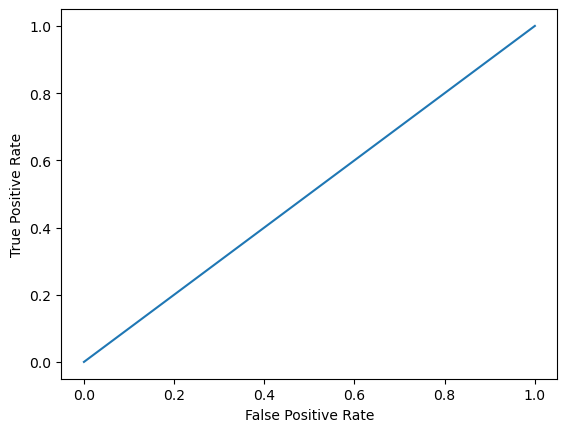

AUC score: 0.5


In [36]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [37]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)